# Modèle BERT pour la Classification de Sentiments

Ce notebook implémente un modèle BERT (Bidirectional Encoder Representations from Transformers) pour la classification de sentiments des tweets.

**Objectif**: Fine-tuner un modèle BERT pré-entraîné sur notre dataset de tweets pour la classification binaire (positif/négatif).

**Approche**: Utilisation de `TFBertForSequenceClassification` de Hugging Face avec tokenisation BERT et préparation des input_ids et attention_masks.

## 1. Imports et Configuration

In [1]:
import pandas as pd
import numpy as np
import mlflow
import time
import os
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

from transformers import BertTokenizer, TFBertForSequenceClassification

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices("GPU")
print(f"GPU disponible: {gpus}")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-12-30 12:26:11.077197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/mnt/c/Users/Thomas/Documents/Code/openclassrooms/openclassrooms-projet7/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.20.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Configuration MLFlow

In [2]:
# Configuration MLFlow
mlflow.set_tracking_uri("file:///home/thomas/mlruns")
mlflow.set_experiment("air-paradis-sentiment-analysis")

def log_metrics_to_mlflow(model_name, metrics_dict, model=None, training_time=None, prediction_time=None):
    """
    Fonction pour logger les métriques dans MLFlow de manière standardisée.
    
    Args:
        model_name: Nom du modèle
        metrics_dict: Dictionnaire contenant les métriques
        model: Modèle TensorFlow (optionnel)
        training_time: Temps d'entraînement en secondes
        prediction_time: Temps de prédiction en secondes
    """
    # Log des métriques
    for metric_name, metric_value in metrics_dict.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # Log des temps
    if training_time:
        mlflow.log_metric("training_time_seconds", training_time)
    if prediction_time:
        mlflow.log_metric("prediction_time_seconds", prediction_time)
    
    # Log du modèle
    if model:
        mlflow.tensorflow.log_model(model, "model")
    
    print(f"✓ Métriques loggées dans MLFlow pour {model_name}")

/mnt/c/Users/Thomas/Documents/Code/openclassrooms/openclassrooms-projet7/.venv/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


## 3. Chargement des Données

Pour BERT, nous utilisons les données **brutes** (non prétraitées) car BERT a son propre tokenizer qui gère la tokenisation, la casse, et les caractères spéciaux de manière optimale.

In [3]:
# Chargement des données originales (avant preprocessing NLTK)
# BERT fonctionne mieux avec le texte brut car il a son propre tokenizer
print("Chargement des données...")

# Pour l'entraînement BERT, nous allons utiliser un subset plus petit pour des raisons de temps
# BERT est très coûteux en ressources
SAMPLE_SIZE = 50000  # 50k tweets par set (ajustable selon vos ressources)
# SAMPLE_SIZE = None 

# Charger les données originales
train_df = pd.read_csv('../data/processed/train_lemmatized.csv').sample(n=SAMPLE_SIZE, random_state=42)
val_df = pd.read_csv('../data/processed/val_lemmatized.csv').sample(n=int(SAMPLE_SIZE * 0.2), random_state=42)
test_df = pd.read_csv('../data/processed/test_lemmatized.csv').sample(n=int(SAMPLE_SIZE * 0.2), random_state=42)

# Pour BERT, nous utilisons le texte (même prétraité, BERT s'en sortira bien)
# Note: Idéalement, on utiliserait le texte complètement brut, mais le texte lemmatisé fonctionne aussi

print(f"Train: {len(train_df)} tweets")
print(f"Validation: {len(val_df)} tweets")
print(f"Test: {len(test_df)} tweets")

# Vérification
print("\nExemple de tweet:")
print(train_df['text'].iloc[0])
print(f"\nSentiment: {train_df['sentiment'].iloc[0]}")

Chargement des données...
Train: 50000 tweets
Validation: 10000 tweets
Test: 10000 tweets

Exemple de tweet:
good night world really want get lacrosse game tomorrow

Sentiment: 0


## 4. Tokenisation BERT

BERT nécessite une tokenisation spécifique qui:
- Convertit le texte en tokens BERT (WordPiece)
- Ajoute les tokens spéciaux [CLS] et [SEP]
- Crée les input_ids (IDs des tokens)
- Crée les attention_masks (masque pour indiquer les vrais tokens vs padding)

In [4]:
# Initialisation du tokenizer BERT
print("Initialisation du tokenizer BERT...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Configuration de la longueur maximale des séquences
MAX_LENGTH = 128  # Longueur maximale des tweets (ajustable)

def tokenize_data(texts, labels, max_length=MAX_LENGTH):
    """
    Tokenise les textes avec le tokenizer BERT.
    
    Returns:
        input_ids: IDs des tokens
        attention_masks: Masques d'attention
        labels: Labels
    """
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )
    
    return encodings['input_ids'], encodings['attention_mask'], tf.constant(labels.values)

print("Tokenisation des données...")
start_time = time.time()

# Tokenisation
train_input_ids, train_attention_masks, train_labels = tokenize_data(train_df['text'], train_df['sentiment'])
val_input_ids, val_attention_masks, val_labels = tokenize_data(val_df['text'], val_df['sentiment'])
test_input_ids, test_attention_masks, test_labels = tokenize_data(test_df['text'], test_df['sentiment'])

tokenization_time = time.time() - start_time
print(f"✓ Tokenisation terminée en {tokenization_time:.2f}s")

# Vérification des dimensions
print(f"\nDimensions:")
print(f"Train input_ids: {train_input_ids.shape}")
print(f"Train attention_masks: {train_attention_masks.shape}")
print(f"Train labels: {train_labels.shape}")

# Exemple de tokenisation
print(f"\nExemple de tokenisation:")
print(f"Texte original: {train_df['text'].iloc[0]}")
print(f"Input IDs: {train_input_ids[0][:20]}...")  # Premiers 20 tokens
print(f"Attention mask: {train_attention_masks[0][:20]}...")  # Premiers 20 masques

Initialisation du tokenizer BERT...


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenisation des données...


I0000 00:00:1767094063.941191     776 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5527 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.9


✓ Tokenisation terminée en 13.88s

Dimensions:
Train input_ids: (50000, 128)
Train attention_masks: (50000, 128)
Train labels: (50000,)

Exemple de tokenisation:
Texte original: good night world really want get lacrosse game tomorrow
Input IDs: [  101  2204  2305  2088  2428  2215  2131 13488  2208  4826   102     0
     0     0     0     0     0     0     0     0]...
Attention mask: [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]...


## 5. Création des Datasets TensorFlow

In [5]:
BATCH_SIZE = 28  # Batch size pour BERT (ajustable selon la mémoire GPU)

# Création des datasets
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_input_ids,
    'attention_mask': train_attention_masks
}, train_labels))

val_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_input_ids,
    'attention_mask': val_attention_masks
}, val_labels))

test_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_masks
}, test_labels))

# Configuration des datasets pour l'entraînement
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"✓ Datasets créés avec batch_size={BATCH_SIZE}")

✓ Datasets créés avec batch_size=28


## 6. Construction du Modèle BERT

Nous utilisons `TFBertForSequenceClassification` qui est un modèle BERT pré-entraîné avec une couche de classification ajoutée.

In [6]:
def build_bert_model():
    """
    Construit un modèle BERT pour la classification binaire.
    """
    from transformers import create_optimizer
    
    model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,  # Classification binaire
        use_safetensors=False  # Évite les problèmes de compatibilité
    )
    
    # Note: Pas besoin de compiler manuellement pour BERT
    # Le modèle est déjà configuré pour l'entraînement
    
    return model

print("Construction du modèle BERT...")
bert_model = build_bert_model()

print("\n" + "="*80)
print("ARCHITECTURE DU MODÈLE BERT")
print("="*80)
print(f"✓ Modèle BERT chargé: bert-base-uncased")
print(f"✓ Nombre de labels: 2 (classification binaire)")
print(f"✓ Paramètres: ~110M")
print("="*80)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Construction du modèle BERT...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ARCHITECTURE DU MODÈLE BERT
✓ Modèle BERT chargé: bert-base-uncased
✓ Nombre de labels: 2 (classification binaire)
✓ Paramètres: ~110M


## 7. Entraînement du Modèle

In [7]:
# Configuration de l'entraînement
EPOCHS = 3  # 3-4 epochs sont généralement suffisants pour BERT
LEARNING_RATE = 2e-5

# Création de l'optimizer et compilation
from transformers import create_optimizer

# Calculer le nombre de steps
num_train_steps = len(train_dataset) * EPOCHS

optimizer, lr_schedule = create_optimizer(
    init_lr=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=int(num_train_steps * 0.1),  # 10% de warmup
)

# Compiler le modèle avec le bon optimizer
bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Début du run MLFlow
with mlflow.start_run(run_name="BERT-base-uncased"):
    # Log des hyperparamètres
    mlflow.log_param("model_type", "BERT")
    mlflow.log_param("pretrained_model", "bert-base-uncased")
    mlflow.log_param("max_length", MAX_LENGTH)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("train_samples", len(train_df))
    mlflow.log_param("val_samples", len(val_df))
    
    print("\nDébut de l'entraînement...")
    print("="*80)
    print("Note: Entraînement de 3 epochs sans early stopping")
    print("="*80)
    
    start_time = time.time()
    
    # Entraînement (sans callbacks pour éviter les problèmes de compatibilité)
    history = bert_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    print("="*80)
    print(f"✓ Entraînement terminé en {training_time:.2f}s ({training_time/60:.2f} minutes)")
    
    # Log du temps d'entraînement
    mlflow.log_metric("training_time_seconds", training_time)
    mlflow.log_metric("training_time_minutes", training_time/60)


Début de l'entraînement...
Note: Entraînement de 3 epochs sans early stopping
Epoch 1/3


2025-12-30 12:28:10.608772: I external/local_xla/xla/service/service.cc:163] XLA service 0x7815545803a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-30 12:28:10.608806: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-12-30 12:28:10.657810: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-30 12:28:10.745807: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
I0000 00:00:1767094090.875851    1193 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1786/1786 [==============================] - 654s 348ms/step - loss: 0.5116 - accuracy: 0.7426 - val_loss: 0.4789 - val_accuracy: 0.7785
Epoch 2/3
1786/1786 [==============================] - 603s 338ms/step - loss: 0.3997 - accuracy: 0.8203 - val_loss: 0.5005 - val_accuracy: 0.7836
Epoch 3/3
1786/1786 [==============================] - 599s 335ms/step - loss: 0.2948 - accuracy: 0.8772 - val_loss: 0.5468 - val_accuracy: 0.7843
✓ Entraînement terminé en 1855.90s (30.93 minutes)


## 8. Visualisation de l'Entraînement

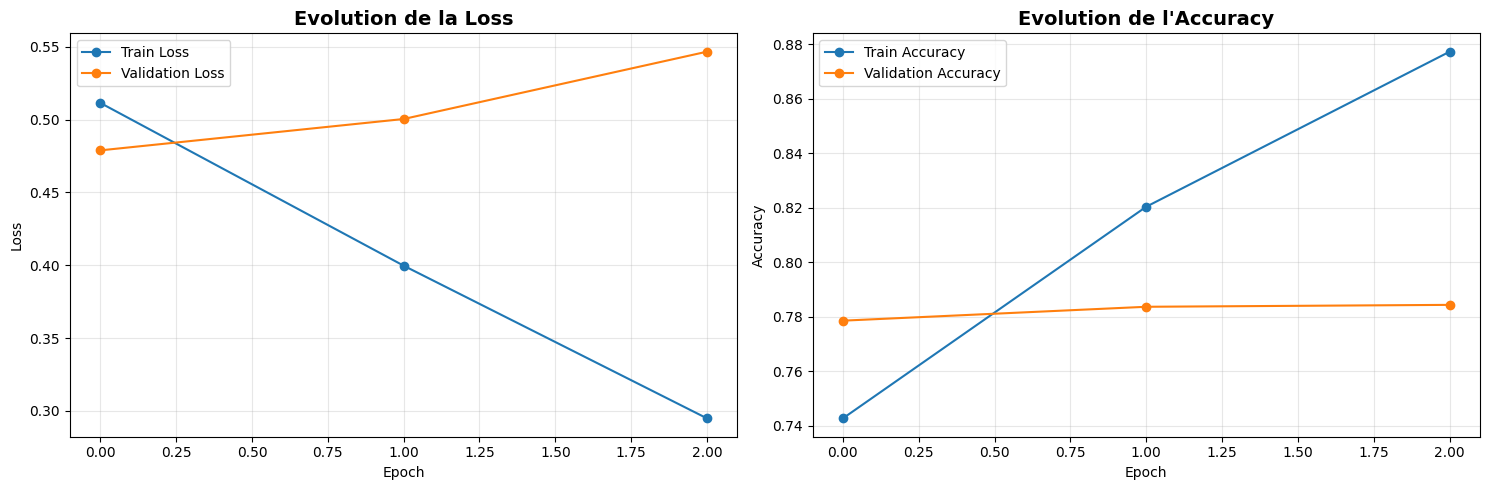

In [8]:
# Graphique d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='o')
axes[0].set_title('Evolution de la Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[1].set_title('Evolution de l\'Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bert_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Log dans MLFlow
with mlflow.start_run(run_name="bert_training_history"):
    mlflow.log_artifact('bert_training_history.png')

## 9. Évaluation sur le Set de Validation

In [9]:
print("Évaluation sur le set de validation...")

# Prédictions
start_time = time.time()
val_predictions = bert_model.predict(val_dataset)
prediction_time = time.time() - start_time

# Extraction des logits et conversion en classes
val_logits = val_predictions.logits
val_pred_classes = np.argmax(val_logits, axis=1)

# Probabilités (pour ROC-AUC)
val_probabilities = tf.nn.softmax(val_logits, axis=1).numpy()[:, 1]

# Calcul des métriques
val_metrics = {
    'val_accuracy': accuracy_score(val_labels.numpy(), val_pred_classes),
    'val_precision': precision_score(val_labels.numpy(), val_pred_classes),
    'val_recall': recall_score(val_labels.numpy(), val_pred_classes),
    'val_f1_score': f1_score(val_labels.numpy(), val_pred_classes),
    'val_roc_auc': roc_auc_score(val_labels.numpy(), val_probabilities)
}

print("\n" + "="*80)
print("RÉSULTATS SUR LE SET DE VALIDATION")
print("="*80)
print(f"Accuracy:  {val_metrics['val_accuracy']:.4f}")
print(f"Precision: {val_metrics['val_precision']:.4f}")
print(f"Recall:    {val_metrics['val_recall']:.4f}")
print(f"F1-Score:  {val_metrics['val_f1_score']:.4f}")
print(f"ROC-AUC:   {val_metrics['val_roc_auc']:.4f}")
print(f"\nTemps de prédiction: {prediction_time:.2f}s")
print("="*80)

# Log dans MLFlow
with mlflow.start_run(run_name=f"BERT_metrics_{prediction_time}"):
    log_metrics_to_mlflow(
        "BERT",
        val_metrics,
        prediction_time=prediction_time
    )

Évaluation sur le set de validation...
358/358 [==============================] - 44s 119ms/step

RÉSULTATS SUR LE SET DE VALIDATION
Accuracy:  0.7843
Precision: 0.7746
Recall:    0.7818
F1-Score:  0.7782
ROC-AUC:   0.8596

Temps de prédiction: 43.97s
✓ Métriques loggées dans MLFlow pour BERT


## 10. Matrice de Confusion

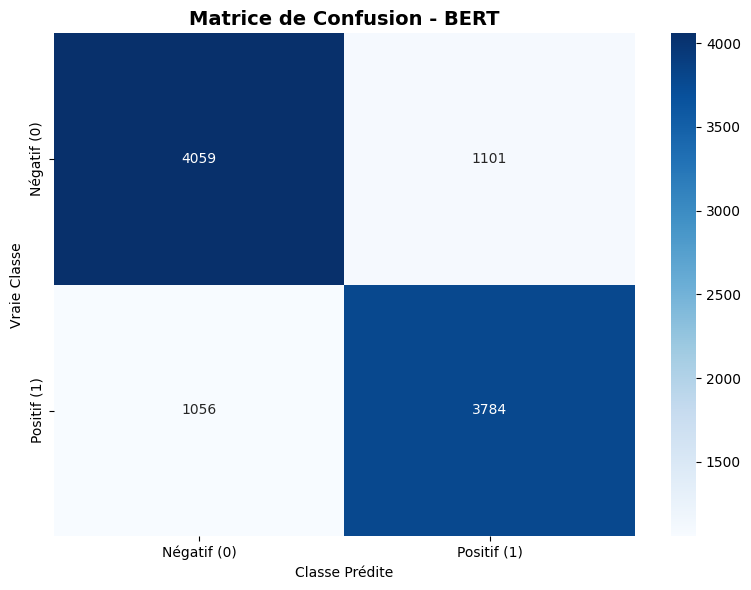


RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

     Négatif       0.79      0.79      0.79      5160
     Positif       0.77      0.78      0.78      4840

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [10]:
# Matrice de confusion
cm = confusion_matrix(val_labels.numpy(), val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Matrice de Confusion - BERT', fontsize=14, fontweight='bold')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.xticks([0.5, 1.5], ['Négatif (0)', 'Positif (1)'])
plt.yticks([0.5, 1.5], ['Négatif (0)', 'Positif (1)'])
plt.tight_layout()
plt.savefig('bert_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Log dans MLFlow
with mlflow.start_run(run_name="bert_confusion_matrix"):
    mlflow.log_artifact('bert_confusion_matrix.png')

# Rapport de classification détaillé
print("\n" + "="*80)
print("RAPPORT DE CLASSIFICATION")
print("="*80)
print(classification_report(val_labels.numpy(), val_pred_classes, 
                          target_names=['Négatif', 'Positif']))
print("="*80)

## 11. Évaluation Finale sur le Set de Test

In [11]:
print("Évaluation finale sur le set de test...")

# Prédictions sur le test
test_predictions = bert_model.predict(test_dataset)
test_logits = test_predictions.logits
test_pred_classes = np.argmax(test_logits, axis=1)
test_probabilities = tf.nn.softmax(test_logits, axis=1).numpy()[:, 1]

# Métriques finales
test_metrics = {
    'test_accuracy': accuracy_score(test_labels.numpy(), test_pred_classes),
    'test_precision': precision_score(test_labels.numpy(), test_pred_classes),
    'test_recall': recall_score(test_labels.numpy(), test_pred_classes),
    'test_f1_score': f1_score(test_labels.numpy(), test_pred_classes),
    'test_roc_auc': roc_auc_score(test_labels.numpy(), test_probabilities)
}

print("\n" + "="*80)
print("RÉSULTATS FINAUX SUR LE SET DE TEST")
print("="*80)
print(f"Accuracy:  {test_metrics['test_accuracy']:.4f}")
print(f"Precision: {test_metrics['test_precision']:.4f}")
print(f"Recall:    {test_metrics['test_recall']:.4f}")
print(f"F1-Score:  {test_metrics['test_f1_score']:.4f}")
print(f"ROC-AUC:   {test_metrics['test_roc_auc']:.4f}")
print("="*80)

# Log dans MLFlow
with mlflow.start_run(run_name="bert_metrics_final"):
    for metric_name, metric_value in test_metrics.items():
        mlflow.log_metric(metric_name, metric_value)

Évaluation finale sur le set de test...
358/358 [==============================] - 41s 115ms/step

RÉSULTATS FINAUX SUR LE SET DE TEST
Accuracy:  0.7782
Precision: 0.7744
Recall:    0.7772
F1-Score:  0.7758
ROC-AUC:   0.8604


## 12. Sauvegarde du Modèle

In [12]:
# Créer le dossier si nécessaire
os.makedirs('../models', exist_ok=True)

# Sauvegarde du modèle complet
model_path = '../models/bert_sentiment_model'
bert_model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"✓ Modèle BERT sauvegardé dans: {model_path}")

# Log dans MLFlow
with mlflow.start_run(run_name="bert_save_model"):
    mlflow.log_artifact(model_path)

✓ Modèle BERT sauvegardé dans: ../models/bert_sentiment_model


## 13. Test de Prédiction sur des Exemples

In [13]:
def predict_sentiment(text, model, tokenizer, max_length=MAX_LENGTH):
    """
    Prédit le sentiment d'un texte.
    
    Returns:
        sentiment: 'Positif' ou 'Négatif'
        probability: Probabilité de la classe prédite
    """
    # Tokenisation
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )
    
    # Prédiction
    outputs = model(encoding)
    logits = outputs.logits
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    
    predicted_class = np.argmax(probabilities)
    sentiment = 'Positif' if predicted_class == 1 else 'Négatif'
    confidence = probabilities[predicted_class]
    
    return sentiment, confidence

# Tests sur des exemples
test_examples = [
    "This flight was amazing! Best experience ever!",
    "Terrible service, never flying with them again",
    "The staff was friendly and helpful",
    "Delayed for 5 hours, worst airline",
    "Good value for money"
]

print("\n" + "="*80)
print("TESTS DE PRÉDICTION")
print("="*80)

for text in test_examples:
    sentiment, confidence = predict_sentiment(text, bert_model, tokenizer)
    print(f"\nTexte: {text}")
    print(f"Sentiment prédit: {sentiment} (confiance: {confidence:.2%})")

print("\n" + "="*80)


TESTS DE PRÉDICTION

Texte: This flight was amazing! Best experience ever!
Sentiment prédit: Positif (confiance: 99.62%)

Texte: Terrible service, never flying with them again
Sentiment prédit: Négatif (confiance: 99.22%)

Texte: The staff was friendly and helpful
Sentiment prédit: Positif (confiance: 97.43%)

Texte: Delayed for 5 hours, worst airline
Sentiment prédit: Négatif (confiance: 99.28%)

Texte: Good value for money
Sentiment prédit: Positif (confiance: 95.93%)



## 14. Comparaison avec les Autres Modèles

Cette section sera complétée après avoir exécuté tous les notebooks pour comparer:
- Modèle simple (Logistic Regression)
- Modèles avancés (Bi-LSTM, CNN avec Word2Vec/GloVe)
- Modèle BERT

Critères de comparaison:
1. **Performance**: Accuracy, F1-Score, ROC-AUC
2. **Temps d'entraînement**: Combien de temps pour entraîner?
3. **Temps de prédiction**: Vitesse d'inférence
4. **Complexité**: Nombre de paramètres, ressources nécessaires
5. **Facilité de déploiement**: Taille du modèle, dépendances

In [14]:
# Cette cellule sera utilisée pour créer un tableau comparatif final
# après avoir exécuté tous les notebooks

print("\n" + "="*80)
print("RÉSUMÉ DES PERFORMANCES - BERT")
print("="*80)
print(f"\nValidation Set:")
for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")

print(f"\nTest Set:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")

print(f"\nTemps d'entraînement: {training_time/60:.2f} minutes")
print(f"Temps de prédiction: {prediction_time:.2f} secondes")
print("="*80)


RÉSUMÉ DES PERFORMANCES - BERT

Validation Set:
  val_accuracy: 0.7843
  val_precision: 0.7746
  val_recall: 0.7818
  val_f1_score: 0.7782
  val_roc_auc: 0.8596

Test Set:
  test_accuracy: 0.7782
  test_precision: 0.7744
  test_recall: 0.7772
  test_f1_score: 0.7758
  test_roc_auc: 0.8604

Temps d'entraînement: 30.93 minutes
Temps de prédiction: 43.97 secondes


## Conclusion

Ce notebook a implémenté un modèle BERT pour la classification de sentiments de tweets.

**Points clés:**
- Utilisation de `bert-base-uncased` pré-entraîné
- Fine-tuning sur notre dataset de tweets
- Préparation appropriée des données (input_ids, attention_masks)
- Tracking complet avec MLFlow

**Prochaines étapes:**
1. Comparer BERT avec les modèles précédents
2. Choisir le meilleur modèle pour le déploiement
3. Créer l'API pour le modèle sélectionné
4. Déployer sur le Cloud
5. Mettre en place le monitoring avec Azure Application Insights